# Impact Classifier

The project proposes to leverage machine learning (ML) and natural language processing (NLP) techniques to build a text classifier that automatizes the processing and identification of evidence of social impact in research documents. The proposal aims to solve a classification problem in which the model takes a sentence contained in a research document as input and produces as output a binary answer (1=True, 0=False) that states whether the sentence contains or not evidence of social impact, respectively.

From all research fields, this project focuses on Medical, Health, and Biological science because the ultimately goal is to understand the social impact of the research projects of the Spanish National Institue of Bioinformatics (INB by its Spanish Acronym), which is an institution that conducts medical and biological investigations.

The goal of this notebook is to describe the methodology followed to develop a machine learning classifier able to automatically identify sentences of social impact in research documents.

## Load libraries

In [1]:
import glob
import numpy as np
import nltk
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
import sys
import joblib
import json
import pickle
import seaborn as sns


nltk.download("stopwords")
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.probability import FreqDist

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn import model_selection
from sklearn.model_selection import cross_val_score, KFold, RandomizedSearchCV, GridSearchCV, learning_curve, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

from bs4 import BeautifulSoup
from text_processor import *
from tqdm import tqdm
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from utils import save_model, get_features_and_labels, plot_learning_curve

%matplotlib inline
pd.set_option('display.max_colwidth',1000)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/Life/jsaldiva/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/Life/jsaldiva/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/Life/jsaldiva/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/Life/jsaldiva/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Load data

### Impact sentences

Load summaries with sentences with evidence of social impact. The data were extracted from the impact case studies published by REF (Research Excellence Framework) and it contains the summary of societal impact of Medical, Health, and Biological research. Summaries can be access [here](https://impact.ref.ac.uk/casestudies/Results.aspx?Type=I&Tag=5085).

In [2]:
ref_impact = pd.read_csv('data/source/social_impact_ref_bio_medicine.csv', usecols=['Summary of the impact'])

#### Split summaries into sentences

In [3]:
impact_sentences = pd.DataFrame(columns=['sentence'])
for i in ref_impact.index:
    text = ref_impact.loc[i, 'Summary of the impact']
    text = fix_latin_abbreviations(text)
    sentences = sent_tokenize(text)
    for sentence in sentences:
        impact_sentences = impact_sentences.append({'sentence': sentence}, ignore_index=True)        

#### Clean sentences

In [4]:
%%time
impact_sentences['sentence'] = impact_sentences['sentence'].apply(lambda x: clean_sentence(x))

CPU times: user 106 ms, sys: 3.76 ms, total: 110 ms
Wall time: 108 ms


#### Add label column

Sentences with evidence of social will later be merged with more general sentences that can be commonly found in research documents. By the time the merge occurs, social impact sentences need to be distinguised from the more general sentences. Therefore, a the new column **`label`** is created in the impact dataset to tag with 1 all sentences that contain evidence of social impact.  

In [5]:
impact_sentences['label'] = 1

In [6]:
nrows = impact_sentences.shape[0]
ncols = impact_sentences.shape[1]
print(f"The dataset contains {nrows} rows and {ncols} columns")

The dataset contains 2347 rows and 2 columns


Let's show an sample of impact sentences together with the newly created column label.

In [7]:
impact_sentences.head()

,sentence,label
0,The Guide to Receptors and Channels has contributed to the development and maintenance of the intellectual infrastructure of pharmacology,1
1,The key tools it provides have influenced appropriate identification of lead drug targets and how best to study them and as a result it has received endorsement and financial support from the Pharmaceutical Industry,1
2,It is used widely as a teaching aid for undergraduates and research postgraduates and provides the general public with accurate information on prescription drug action,1
3,It led to the formation of the Guide to Pharmacology website in collaboration with the International Union of Basic and Clinical Pharmacology,1
4,The Cardiff Osteological Research Group CORG has researched the complex relationship between animals and people across Britain Europe and beyond,1


### General sentences

Load dataset containing sentences that are commonly found in medical and bioinformatics research documents. The process followed to build the dataset of general sentences is described in the section *Collection of medical and biological sentences* of the notebook **`0.dataset_preparation.ipynb`**.

In [8]:
gral_sentences = pd.read_csv("data/sentences/gral_sentences_3000.csv", index_col=0)

#### Clean sentences

In [9]:
gral_sentences['sentence'] = gral_sentences['sentence'].apply(lambda x: clean_sentence(x))

#### Add label column

As in the case of the dataset of impact sentences, here a column **`label`** is also created to tag with 0 all general sentences.

In [10]:
gral_sentences['label'] = 0

In [11]:
nrows = gral_sentences.shape[0]
ncols = gral_sentences.shape[1]
print(f"The dataset contains {nrows} rows and {ncols} columns")

The dataset contains 3000 rows and 2 columns


Let's show a sample of the dateset

In [12]:
gral_sentences.head()

,sentence,label
0,Tumor and patient characteristics are summarized in Table,0
1,The execution run for days to complete and the performance results in terms of accuracy precision and recall was all under,0
2,Actually a recent study indicated that over expression of stem cell specific transcriptional factors such as OCT SLUG and NANOG in MCF cells reduces ER expression increases the stem cell features and enhances the cell mobility,0
3,The motivation is we need to address the component information of the genes in a gene set,0
4,However based on measurements of estradiol levels in the same individual at different times it has been reported that approximately of the variance in estradiol levels is essentially random fluctuation,0


### Merge datasets

Merge both datasets, the general and impact one.

In [13]:
total_sentences = pd.concat([impact_sentences, gral_sentences], ignore_index=True)

In [14]:
nrows = total_sentences.shape[0]
ncols = total_sentences.shape[1]
print(f"The combined dataset contains {nrows} rows and {ncols} columns")

The combined dataset contains 5347 rows and 2 columns


## Explore data

Next, the dataset is explored by, first, computing the most frequent terms in sentences that contain evidence of social impact and, then, by calculating the most frequent term in general sentences.

In [15]:
word_black_list = ['research', 'uk']  # let's add context specify words that will be filtered before computing frequencies
max_items_to_show = 30

### Most frequent terms in social impact sentences

Inspect the most used terms used in sentences that express evidence of social impact

In [16]:
si_sentences = total_sentences[total_sentences['label']==1]['sentence']
si_words = []
for si_sentence in si_sentences:
    for word in si_sentence.split():
        if len(word) > 2 and word not in word_black_list and word not in stopwords.words('english'):
            si_words.append(word)
fdist = FreqDist(si_words)
freq_words_df = pd.DataFrame(fdist.items(), columns=['word', 'frequency'])

In [17]:
freq_words_df.sort_values(by='frequency', ascending=False, inplace=True)

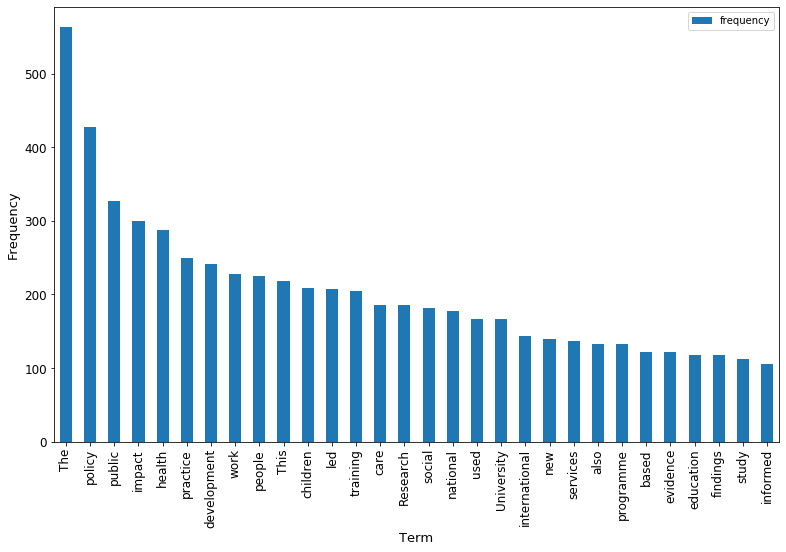

In [18]:
freq_words_df.iloc[0:max_items_to_show,:].plot(x='word', y='frequency', kind='bar', figsize=(13,8))
plt.xticks(rotation=90)
plt.xlabel("Term", size=13)
plt.ylabel("Frequency", size=13)
plt.xticks(size=12)
plt.yticks(size=12)
plt.show()

### Most frequent terms in general sentences

Inspect the most used terms in sentences that do not neccesarily contain evidence of social impact

In [19]:
n_si_sentences = total_sentences[total_sentences['label']==0]['sentence']
n_fdist = FreqDist(word for n_si_sentence in n_si_sentences 
                        for word in n_si_sentence.split() if len(word) > 2 and word not in stopwords.words('english') and word not in word_black_list)
n_freq_words_df = pd.DataFrame(n_fdist.items(), columns=['word', 'frequency'])

In [20]:
n_freq_words_df.sort_values(by='frequency', ascending=False, inplace=True)

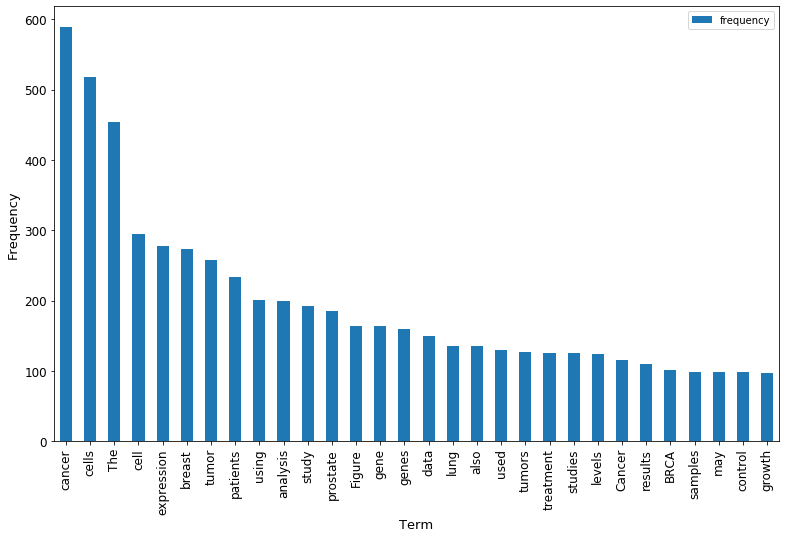

In [21]:
n_freq_words_df.iloc[0:max_items_to_show,:].plot(x='word', y='frequency', kind='bar', figsize=(13,8))
plt.xticks(rotation=90)
plt.xlabel("Term", size=13)
plt.ylabel("Frequency", size=13)
plt.xticks(size=12)
plt.yticks(size=12)
plt.show()

From the figures above it can be seen there is little overlap between the most frequent terms in sentences with evidence of social impact (e.g., public policy, health, national, development) and the most frequent terms in the general sentences, which, as expected, are more related with medical and biological terminologies, such as cancer, cells, patients, tumor, or therapy. The low interception between the most frequent terms in the two datasets demonstrates the potential of the data to train a machine learning classifier. 

## Augment data with additional syntactical and semantical features

Augment data of sentences with the following text-based extra features:
1. **Word count of sentences**: total number of words in sentences
2. **Character count of sentences**: total number of characters in sentences
3. **Average word density of sentences**: average length of words in sentences
4. **Upper case count in sentences**: total number of upper count words in sentences
5. **Title word count in sentences**: total number of title case words in sentences

In [15]:
total_sentences['char_count'] = total_sentences['sentence'].apply(len)
total_sentences['word_count'] = total_sentences['sentence'].apply(lambda x: len(x.split()))
total_sentences['word_density'] = total_sentences['char_count'] / (total_sentences['word_count']+1)
total_sentences['upper_case_word_count'] = total_sentences['sentence'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))
total_sentences['title_word_count'] = total_sentences['sentence'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))

Also, we add frequency distribution of part-of-speech tags

In [16]:
%%time
total_sentences['noun_count'] = total_sentences['sentence'].apply(lambda x: count_pos_tag(x, 'noun'))
total_sentences['verb_count'] = total_sentences['sentence'].apply(lambda x: count_pos_tag(x, 'verb'))
total_sentences['adj_count'] = total_sentences['sentence'].apply(lambda x: count_pos_tag(x, 'adj'))
total_sentences['adv_count'] = total_sentences['sentence'].apply(lambda x: count_pos_tag(x, 'adv'))
total_sentences['pron_count'] = total_sentences['sentence'].apply(lambda x: count_pos_tag(x, 'pron'))

CPU times: user 46.3 s, sys: 423 ms, total: 46.7 s
Wall time: 46.7 s


In [17]:
total_sentences.head()

,sentence,label,char_count,word_count,word_density,upper_case_word_count,title_word_count,noun_count,verb_count,adj_count,adv_count,pron_count
0,The Guide to Receptors and Channels has contributed to the development and maintenance of the intellectual infrastructure of pharmacology,1,137,19,6.850000,0,4,7,2,1,0,0
1,The key tools it provides have influenced appropriate identification of lead drug targets and how best to study them and as a result it has received endorsement and financial support from the Pharmaceutical Industry,1,215,34,6.142857,0,3,9,7,4,0,0
2,It is used widely as a teaching aid for undergraduates and research postgraduates and provides the general public with accurate information on prescription drug action,1,167,25,6.423077,0,1,10,3,2,1,0
3,It led to the formation of the Guide to Pharmacology website in collaboration with the International Union of Basic and Clinical Pharmacology,1,141,22,6.130435,0,8,10,1,0,0,0
4,The Cardiff Osteological Research Group CORG has researched the complex relationship between animals and people across Britain Europe and beyond,1,144,20,6.857143,1,7,10,2,1,0,0


Include sentiment score of sentences as an additional feature. Sentences with evidence of social impact are expected to have a more positive attitude than general sentences.

In [18]:
total_sentences['sentiment_score'] = total_sentences['sentence'].apply(lambda x: analyze_sentiment(x))

In [19]:
total_sentences.head()

,sentence,label,char_count,word_count,word_density,upper_case_word_count,title_word_count,noun_count,verb_count,adj_count,adv_count,pron_count,sentiment_score
0,The Guide to Receptors and Channels has contributed to the development and maintenance of the intellectual infrastructure of pharmacology,1,137,19,6.850000,0,4,7,2,1,0,0,0.5106
1,The key tools it provides have influenced appropriate identification of lead drug targets and how best to study them and as a result it has received endorsement and financial support from the Pharmaceutical Industry,1,215,34,6.142857,0,3,9,7,4,0,0,0.8481
2,It is used widely as a teaching aid for undergraduates and research postgraduates and provides the general public with accurate information on prescription drug action,1,167,25,6.423077,0,1,10,3,2,1,0,0.0000
3,It led to the formation of the Guide to Pharmacology website in collaboration with the International Union of Basic and Clinical Pharmacology,1,141,22,6.130435,0,8,10,1,0,0,0,0.0000
4,The Cardiff Osteological Research Group CORG has researched the complex relationship between animals and people across Britain Europe and beyond,1,144,20,6.857143,1,7,10,2,1,0,0,0.0000


Print out mean sentiment scores of both sentences with evidence of social impact (1) and general sentences (0).

In [20]:
total_sentences.groupby(['label'])['sentiment_score'].mean()

label
0   -0.059345
1    0.217703
Name: sentiment_score, dtype: float64

## Split dataset in train and test

In [21]:
features, labels = pd.concat([total_sentences['sentence'], total_sentences.iloc[:,2:]], axis=1), total_sentences['label']
random_state = np.random.RandomState(1234)  # set a random seed for reproducibility purposes
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.20, random_state=random_state)

In [22]:
X_train.head()

,sentence,char_count,word_count,word_density,upper_case_word_count,title_word_count,noun_count,verb_count,adj_count,adv_count,pron_count,sentiment_score
5193,Metastatic cancer cells express human CD no human CD positive cells are detected in controls,92,15,5.750000,2,1,6,2,5,0,0,-0.4588
2294,Professor Simeon Nelson s research into cancer from multiple perspectives led to the creation of a site specific artwork Anarchy in the Organism a genuinely successful interdisciplinary project in which oncology visual art music computer science psychology and sociology came into enriching interaction,302,43,6.863636,0,5,19,5,5,1,0,0.1280
2812,reported that hypoxia inducible factor activates the transcription of P HA and during breast cancer development and this activation enhances collagen fiber alignment and breast cancer progression,195,27,6.964286,2,1,15,3,1,0,0,-0.7695
3677,Data are representative of three independent experiments in duplicate wells,75,10,6.818182,0,1,4,1,2,0,0,0.2500
140,Outcomes from CBR have been shown to increase independence and enhance mobility and social inclusion of people with disabilities in low and middle income nations,161,25,6.192308,1,1,10,4,3,0,0,0.0516


In [23]:
X_test.head()

,sentence,char_count,word_count,word_density,upper_case_word_count,title_word_count,noun_count,verb_count,adj_count,adv_count,pron_count,sentiment_score
798,We improve Public Health and facilitate personal growth through promoting active lifestyles,91,12,7.000000,0,3,4,2,3,0,0,0.8658
2502,integrin subunits revealed upregulation of specific isoforms in prostate tumor metastasis reinforcing a sniper targeting attack against ECM integrin FAC to stop metastatic spread,178,24,7.120000,2,0,11,4,4,0,0,-0.7845
199,This case study describes the impact of research on new approaches to the organisation and delivery of social work services for children in out of home care with international work led by Bilson and work in England involving Stanley Bilson Larkins and Ridley,258,43,5.863636,0,7,20,3,3,0,0,0.4939
2478,For patients who received IVBs during follow up time to IVB therapy interruption and IVB therapy discontinuation were analyzed,126,19,6.300000,2,1,9,4,0,0,1,-0.3612
545,The Work Related Quality of Life WRQoL scale and its derivatives have been used to assess and enhance the quality of working life in of UK universities ten NHS Trusts five Trade Unions schools a professional body the British Psychological Society and parts of other large national organisations Police BBC RNLI,310,51,5.961538,4,12,24,7,5,0,0,0.4767


## Prepare sentences

Data will be prepared using the following combinations of the text processing tasks defined in `sentence_to_words`:
1. Sentence is tokenized and stop words as well as URLs are removed. Stemming is also applied;
2. Sentence is tokenized, stop words and URLs are removed and stemming and lemmatization are applied.


In [24]:
context_words = ['reseach', 'uk']

In [25]:
%%time
X_train_clean = [sentence_to_words(sentence, context_words) for sentence in X_train['sentence']]
X_train_clean_with_lemmatization = [sentence_to_words(sentence, context_words, lemmatization=True) for sentence in X_train['sentence']]
X_test_clean = [sentence_to_words(sentence, context_words) for sentence in X_test['sentence']]
X_test_clean_with_lemmatization = [sentence_to_words(sentence, context_words, lemmatization=True) for sentence in X_test['sentence']]

CPU times: user 9.48 s, sys: 518 ms, total: 10 s
Wall time: 10 s


Save preprocess text into a dictionary to avoid carrying around the recently create variables

In [26]:
preprocess_text = {
    'clean': {'train': {'X_train': X_train_clean, 'y_train': y_train, 'extra_features': X_train.iloc[:,1:]},
              'test': {'X_test': X_test_clean, 'y_test': y_test, 'extra_features': X_test.iloc[:,1:]}},
    'clean_lemmatization': {'train': {'X_train': X_train_clean_with_lemmatization, 'y_train': y_train, 'extra_features': X_train.iloc[:,1:]},
                            'test': {'X_test': X_test_clean_with_lemmatization, 'y_test': y_test, 'extra_features': X_test.iloc[:,1:]}}
}

Check a sample of the preprocess data

In [29]:
preprocess_text['clean_lemmatization']['test']['X_test'][0]

['improve',
 'public',
 'health',
 'facilitate',
 'personal',
 'growth',
 'promoting',
 'active',
 'lifestyle']

### Vectorize text

Previously processed sentences are transformed here to a vectorized representation. After transformation, data are saved into binary files.

#### Define transformation conditions

In [30]:
transformations = ['tc', 'tfidf']
max_features=[500, 800, 1000, 2000, 5000]
ngram_ranges=[(1,1),(1,2),(1,3),(2,3)]
total_cycles = len(transformations)*len(max_features)*len(ngram_ranges)*len(preprocess_text)

#### Transform and save data

In [31]:
def save_transformed_txt(transformation_type, max_features, ngram_range, processing_task, vocabulary,
                         transformed_train_txt, train_labels, train_extra_features, 
                         transformed_test_txt, test_labels, test_extra_features):
        str_ngram_range = str(ngram_range).replace('(','').replace(')','').replace(',','_')
        data_filename = f'data_{transformation_type}_{max_features}_{str_ngram_range}_{processing_task}.pkl'
        # train data
        train_data = pd.DataFrame({'sentence': list(transformed_train_txt), 'label': train_labels})
        train_data = pd.concat([train_data, train_extra_features], axis=1)        
        # save train data        
        dict_data = dict(data=train_data, transformation=transformation_type, max_features=max_features, ngram_range=ngram_range,
                         processing_task=processing_task, vocabulary=vocabulary)        
        with open(os.path.join('data', 'train', data_filename), 'wb') as f:
            joblib.dump(dict_data, f)
        # test data
        test_data = pd.DataFrame({'sentence': list(transformed_test_txt), 'label': test_labels})
        test_data = pd.concat([test_data, test_extra_features], axis=1)
        # save test data
        dict_data = dict(data=test_data, transformation=transformation_type, max_features=max_features, ngram_range=ngram_range,
                         processing_task=processing_task, vocabulary=vocabulary)
        with open(os.path.join('data', 'test', data_filename), 'wb') as f:
            joblib.dump(dict_data, f)

In [32]:
with tqdm(total=total_cycles, file=sys.stdout) as pbar:
    for transformation in transformations:        
        for max_feature in max_features:
            for ngram_range in ngram_ranges:
                for processing_task, data_dict in preprocess_text.items():                    
                    train_text = data_dict['train']['X_train']
                    transformed_train_data, vectorizer = extract_BoW_features(train_text, max_feature, transformation, ngram_range)
                    test_text = data_dict['test']['X_test']
                    transformed_test_data = vectorizer.transform(test_text).toarray()
                    vocabulary = vectorizer.vocabulary_
                    save_transformed_txt(transformation, max_feature, ngram_range, processing_task, vocabulary,
                                         transformed_train_data, data_dict['train']['y_train'], data_dict['train']['extra_features'],
                                         transformed_test_data, data_dict['test']['y_test'], data_dict['test']['extra_features'])
                    pbar.update(1)

100%|██████████| 80/80 [02:43<00:00,  2.04s/it]


## Build ML model

Here we build the machine learning classifier. The decision on the algorithms to be used was based on algorithms that have been reported to perform well on unbalanced, small, and textual datasets, which is our case. Therefore, we try the following algorithms: Naive-Bayes, Support Vector Machine, Logistic Regression, Random Forest, and Gradient Boosting.

In bulding the model we proceed as following:
1. Compare the performance of the choosen algorithms by training them in each of the 180 different training sets;
2. Choose the best performing model for each algorithm;
3. Perform hyper-parameters optimization for the best models, except Naive-Bayes. GridSearch is used for SVM and Logistic Regression while RandomGridSearch with 100 iterations is employed for Random Forest and Gradient Boosting;
4. Plot learning curves for the best models to analyze the overfitting effect on the training set and the effect of the training size on the performance metric;
5. Select the model that best generalize the prediction.

Models are trained using the cross-validation approach. The performance metric to be optimized is **`recall`** because, in spite of over-identifying sentences that might not contain evidence of social impact and even when more sentences mean an overload of work for evaluators, the aim is to avoid losing sentences that can potentially contain evidence of impact and thus might be deciding in understanding the social impact of the research.

The processes of training the different algorithms has been run outside the notebook through the script `train.py`

#### Load training results to a csv

In [60]:
output_df = pd.read_csv(os.path.join('experiments', 'e_24062020_212610.csv'))

### Compare the best models of each type

In [61]:
algorithms = ['NB', 'SVM', 'LR', 'RF', 'GB']
metric = 'f1'

In [62]:
mean_best_models, std_best_models = [], []
for algorithm in algorithms:
    best_model = output_df[output_df['algorithm']==algorithm].sort_values(by=[f"mean_{metric}", f"std_{metric}"], ascending=False).head(1)
    mean_metric = best_model[f'mean_{metric}'].values[0]
    std_metric = best_model[f'std_{metric}'].values[0]
    mean_best_models.append(mean_metric)    
    std_best_models.append(std_metric)
    data_fn = best_model['train_data_file'].values[0]    
    print(f'Algorithm: {algorithm}, Mean: {mean_metric}, Std.: {std_metric}, Train Data File: {data_fn}')

Algorithm: NB, Mean: 0.97, Std.: 0.01, Train Data File: data/train/data_tfidf_5000_1_ 2_clean_lemmatization.pkl
Algorithm: SVM, Mean: 0.54, Std.: 0.04, Train Data File: data/train/data_tc_1000_1_ 2_clean_lemmatization.pkl
Algorithm: LR, Mean: 0.94, Std.: 0.02, Train Data File: data/train/data_tc_1000_1_ 3_clean.pkl
Algorithm: RF, Mean: 0.95, Std.: 0.02, Train Data File: data/train/data_tfidf_5000_1_ 2_clean.pkl
Algorithm: GB, Mean: 0.91, Std.: 0.02, Train Data File: data/train/data_tc_1000_1_ 2_clean_lemmatization.pkl


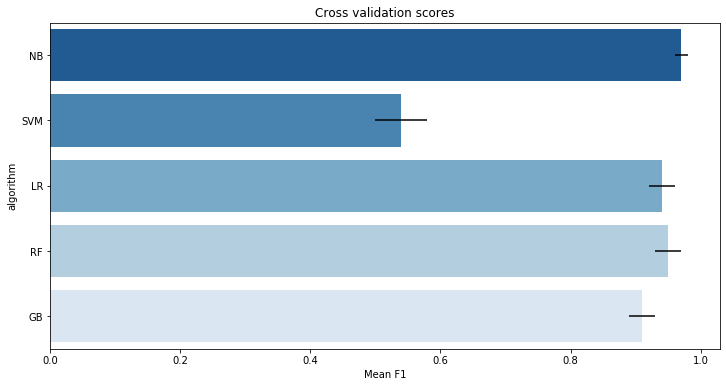

In [64]:
cv_res = pd.DataFrame({
    'cross_val_means': mean_best_models,
    'cross_val_std': std_best_models,
    'algorithm': algorithms
})
plt.figure(figsize=(12,6))
g = sns.barplot('cross_val_means', 'algorithm', data = cv_res, palette='Blues_r', orient = "h", **{'xerr':std_best_models})
g.set_xlabel(f'Mean {metric.title()}')
g = g.set_title('Cross validation scores')

### Perform hyper-parameters optimization

Hyperparametrization processes have been run outside the notebook through the script `train.py`

### Plot learning curves

Except for Naive-Bayes, the rest of the learning curves have been draw outside the notebook through the script `train.py`

#### **Naive-Bayes (NB)**

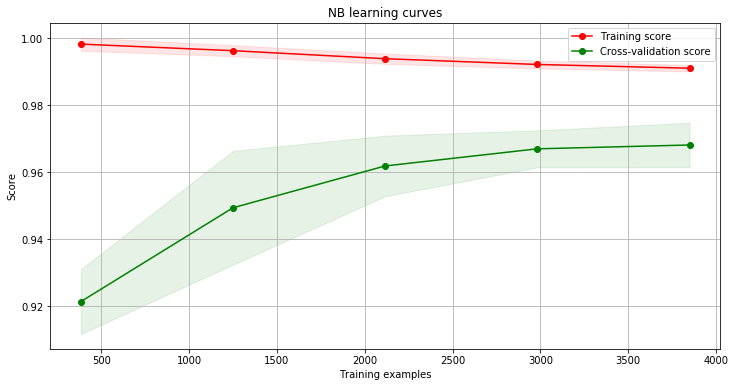

In [65]:
random_state = np.random.RandomState(1234)
kfold = KFold(n_splits=10, shuffle=True, random_state=random_state)
best_model = output_df[output_df['algorithm']=='NB'].sort_values(by=[f'mean_{metric}', f'std_{metric}'], ascending=False).head(1)
train_data_file = best_model['train_data_file'].values[0]
features, labels = get_features_and_labels(train_data_file)
g = plot_learning_curve(GaussianNB(), 'NB learning curves', features, labels, metric, cv=kfold, shuffle=True)
g.show()

**Diagnosis**. Scores in the learning curve of the NB model decrease as the size of the training set increases. This indicates that the model is learning well on the training data. On the other hand, the validation curve increases as more training examples are available and it seems that with more data curves will coverge at some point.

#### **Support Vector Machine (SVM)**

<div>
<img src="figures/SVM learning curves - f1.png" width="800" height="600"/>
</div>

**Diagnosis**. Scores in the learning curve of the SVM model remain constant as the size of the training set increases. This indicates that the model might overfit on the training data (high variance).

#### **Logistic Regression (LR)**

<div>
<img src="figures/LR learning curves - f1.png" width="800" height="600"/>
</div>

**Diagnosis**. Scores in the learning curve of the LR model decrease as the number of training examples increases. This indicate that the model does not overfitting on training data (low variance). On the other hand, the validation curve increases as more training examples are available, which tells us that the model is correctly learning from the training examples. The small gap between curves is a sign of low variance, however the large shadows around curves are an indication of large variability in the scores.

#### **Random Forest (RF)**

<div>
<img src="figures/RF learning curves - f1.png" width="800" height="600"/>
</div>

**Diagnosis**. In this model the training score is at maximum regardless of the training size, which is signal of overfitting. The large gap between curves is strong sign of high-variance.

#### **Gradient Boosting (GB)**

<div>
<img src="figures/GB learning curves - f1.png" width="800" height="600"/>
</div>

**Diagnosis**. In this model the training score is at maximum regardless of the training size, which is signal of overfitting. The large gap between training and validation confirms a high-variance scenario.

### Select model

Although Naive-Bayes and Logistic Regression showed to have pretty good learning results, curves of Logistic Regression converge closer. Based on the this, the **`Logistic Regresssion`** model is selected as the best classifier.

#### Load best model

In [66]:
best_model = joblib.load(f'./models/best_logistic-regression_{metric}.joblib')['model']

#### Save Model

In [67]:
train_fn = output_df[output_df['algorithm']=='LR'].sort_values(by=[f'mean_{metric}', f'std_{metric}'], ascending=False).head(1)['train_data_file'].values[0]
save_model(best_model, 'logistic-regression-classifier', 'data', train_fn)

## Evaluate model

### Load model

In [68]:
model_dict = joblib.load('./models/logistic-regression-classifier.joblib')
model = model_dict['model']

### Load test data

In [69]:
data_fn = model_dict['transformation']['file_name']
test_data_file = os.path.join('data', 'test', data_fn)
X_test, y_test = get_features_and_labels(test_data_file)

### Make predictions

In [70]:
pred = model.predict(X_test)

### Compute performance metrics

In [71]:
print(f'{metric.title()}: {round(metrics.recall_score(y_test, pred),2)}')

F1: 0.94
